# 분류 분석

## 이진 고객 이탈

고객의 웹사이트 광고를 제공하는 마케팅 대행사에서 당사의 고객이탈율이 꽤 높다는 사실을 알게됐습니다.<br>
그 회사에서는 즉시 고객 관리자들을 할당했지만, 어떤 고객이 이탈 할 것인지 예측하는 기계학습 모델을 만들어서 가장 이탈확률이 높은 고객에게 우선적으로 고객 관리자를 배치할 수 있기를 원합니다.<br>
고객이 잠재적 이탈 고객인지 여부를 분류하는 분류모델을 만드세요.

데이터는 customer_churn.csv로 저장돼있습니다. 아래는 각 컬럼의 정의입니다.
- Name : 회사의 최근 담당자의 이름
- Age : 고객의 나이
- Total_Purchase : 구매한 총 광고
- Account_Manager : 바이너리 0 = 고객 관리자 없음, 1 = 고객 관리자 할당됨
- Years : 거래 유지 연도수
- Num_sites : 서비스를 이용 중인 웹사이트 수
- Onboard_date : 마지막 연락처가 등록된 날짜
- Location : 고객 사무실 주소
- Company : 고객 회사의 이름

모델 생성 후에는 고객이 제공하는 new_customers.csv 파일에 저장된 새로운 데이터에 대한 예측값을 제시하세요. <br>
고객은 이 데이터를 통해 관리가 필요한 고객들을 알고 싶어 합니다.

In [2068]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

### 데이터 불러오기

In [2071]:
df = pd.read_csv("./data/customer_churn.csv")

### 데이터 확인

In [2074]:
# 데이터 상위 5행 확인
df.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1


In [2075]:
# 데이터 크기 확인 (행, 열)
df.shape

(900, 10)

In [2076]:
# 데이터 타입 및 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Names            900 non-null    object 
 1   Age              900 non-null    float64
 2   Total_Purchase   900 non-null    float64
 3   Account_Manager  900 non-null    int64  
 4   Years            900 non-null    float64
 5   Num_Sites        900 non-null    float64
 6   Onboard_date     900 non-null    object 
 7   Location         900 non-null    object 
 8   Company          900 non-null    object 
 9   Churn            900 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 70.4+ KB


In [2079]:
df.describe()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,41.816667,10062.824033,0.481111,5.273156,8.587778,0.166667
std,6.127560,2408.644532,0.499921,1.274449,1.764836,0.372885
min,22.000000,100.000000,0.000000,1.000000,3.000000,0.000000
25%,38.000000,8497.122500,0.000000,4.450000,7.000000,0.000000
50%,42.000000,10045.870000,0.000000,5.215000,8.000000,0.000000
75%,46.000000,11760.105000,1.000000,6.110000,10.000000,0.000000
max,65.000000,18026.010000,1.000000,9.150000,14.000000,1.000000


### 머신러닝용 데이터 전처리

우리는 수치형 데이터만 이용할 예정입니다. Account_Manager는 다루기 어렵지 않기 때문에 모델학습에 포함할 수도 있겠지만 무작위로 할당된 것이기 때문에 큰 의미가 없을 수 있습니다.

In [2098]:
df.dtypes

Names               object
Age                float64
Total_Purchase     float64
Account_Manager      int64
Years              float64
Num_Sites          float64
Onboard_date        object
Location            object
Company             object
Churn                int64
dtype: object

In [2100]:
numeric_cols = ["Age", "Total_Purchase", "Years", "Num_Sites"]

In [2102]:
desc = df[numeric_cols].describe().T
desc["skew"] = df[numeric_cols].skew()
desc["missing"] = df[numeric_cols].isnull().sum()
desc

# Skewness ≈ 0: 정규분포 → mean (평균) 사용 권장
# Skewness > 0.5 or < -0.5: 왜곡된 분포 → median (중앙값) 사용 권장

,count,mean,std,min,25%,50%,75%,max,skew,missing
Age,900.0,41.816667,6.127560,22.0,38.0000,42.000,46.000,65.00,0.091482,0
Total_Purchase,900.0,10062.824033,2408.644532,100.0,8497.1225,10045.870,11760.105,18026.01,-0.104441,0
Years,900.0,5.273156,1.274449,1.0,4.4500,5.215,6.110,9.15,0.006281,0
Num_Sites,900.0,8.587778,1.764836,3.0,7.0000,8.000,10.000,14.00,0.185936,0


In [2104]:
# 컬럼별 통계적 특성 고려한 결측치 처리
df.fillna({
    "Age": df["Age"].mean(),                           # 정규분포 → 평균
    "Total_Purchase": df["Total_Purchase"].mean(),     # 거의 대칭 → 평균
    "Years": df["Years"].mean(),                       # 완전 대칭 → 평균
    "Num_Sites": df["Num_Sites"].median(),             # 약간 왜곡 있음 → 중앙값
    "Account_Manager": df["Account_Manager"].mode()[0] # 이진형 → 최빈값
}, inplace=True)

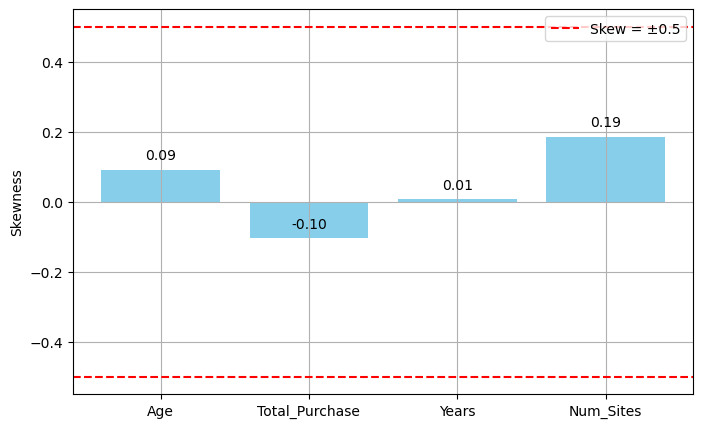

In [2106]:
# 왜곡도 수치 가져오기
skew_vals = df[numeric_cols].skew()

# 막대 그래프
plt.figure(figsize=(8, 5))
bars = plt.bar(skew_vals.index, skew_vals.values, color='skyblue')

# 기준선 표시
plt.axhline(y=0.5, color='red', linestyle='--', label='Skew = ±0.5')
plt.axhline(y=-0.5, color='red', linestyle='--')

# 텍스트로 스큐 수치 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center', va='bottom')

plt.ylabel("Skewness")
plt.legend()
plt.grid(True)
plt.show()

In [2108]:
# 이상치 처리 (Total_Purchase 예시)
Q1 = df["Total_Purchase"].quantile(0.25)
Q3 = df["Total_Purchase"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df["Total_Purchase"] >= lower) & (df["Total_Purchase"] <= upper)]

# 이상치 처리
# def check_outliers(df, col):
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower = Q1 - 1.5 * IQR
#     upper = Q3 + 1.5 * IQR
#     outliers = df[(df[col] < lower) | (df[col] > upper)]
#     return len(outliers), lower, upper

# cols = ["Age", "Total_Purchase", "Years", "Num_Sites"]

# for col in cols:
#     count, low, high = check_outliers(df, col)
#     print(f"[{col}] 이상치 개수: {count} (범위: {low:.1f} ~ {high:.1f})")

#     median = df[col].median()  # <-- 각 변수별 중앙값을 다시 계산
#     df.loc[df[col] < low, col] = median
#     df.loc[df[col] > high, col] = median

In [2110]:
# 파생 변수 생성 (days_since_last_contact)

# 날짜형 datetime 형식으로 변환
# errors="coerce"는 변환 불가한 값을 자동으로 NaT로 처리하여 오류 방지
df["Onboard_date"] = pd.to_datetime(df["Onboard_date"], errors="coerce")

# 고객과 마지막으로 연락한 지 얼마나 오래됐는지
# 소통이 끊긴 기간이 길면 이탈 가능성 높지 않을까?
df["days_since_last_contact"] = (pd.to_datetime("today") - df["Onboard_date"]).dt.days / 365

In [2112]:
# 파생 변수 생성 (purchase_per_site)

# purchase_per_site = 고객이 지금까지 지출한 총 금액 / 고객이 관리하는 웹사이트 수
# Num_Sites이면 0으로 나눌 수 없기에 +1
df["purchase_per_site"] = df["Total_Purchase"] / (df["Num_Sites"] + 1)

In [2114]:
df.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn,days_since_last_contact,purchase_per_site
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1,11.843836,1229.644444
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1,11.890411,993.018333
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1,9.010959,991.134615
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1,11.200000,728.250909
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1,9.454795,919.158000


In [2116]:
# 결측치 제거 후 df_cleaned 생성
df_cleaned = df.dropna(subset=["days_since_last_contact", "purchase_per_site", "Churn"])

In [2118]:
# 사용할 특성 정의 (범주형 제외)
features = [
    "Age", "Total_Purchase", "Account_Manager", "Years", "Num_Sites", "purchase_per_site", "days_since_last_contact"
]

In [2120]:
# 입력(X), 출력(y) 정의
x = df_cleaned[features]
y = df_cleaned["Churn"]

In [2122]:
# 학습용 데이터와 테스트용 데이터 분할 (75:25)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=26)

In [2124]:
x_train.shape, x_test.shape

((671, 7), (224, 7))

In [2126]:
# 타겟 변수의 불균형 확인 (이탈/비이탈 비율)
y.value_counts(normalize=True)

Churn
0    0.83352
1    0.16648
Name: proportion, dtype: float64

In [2128]:
# 특성 스케일링 (표준화)
ss = StandardScaler()
scaled_train = ss.fit_transform(x_train)
scaled_test = ss.transform(x_test)

### 데이터 시각화

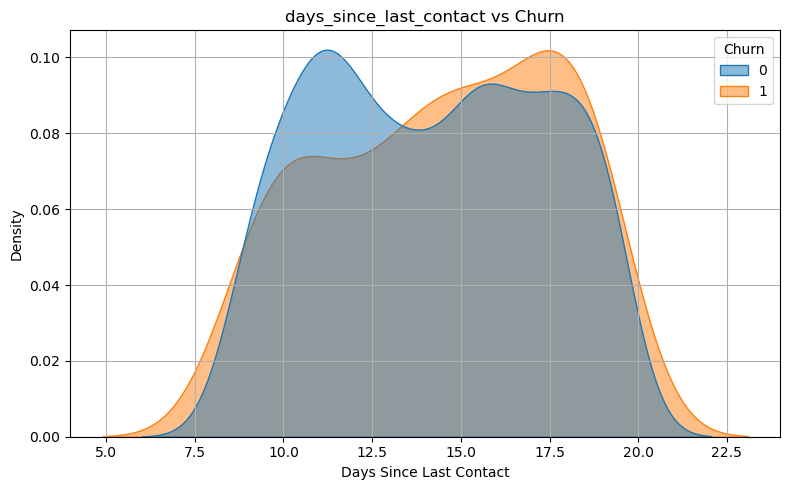

In [2131]:
# 시각화 1: 마지막 연락 후 경과일수 vs 이탈 여부
plt.figure(figsize=(8, 5))

sns.kdeplot(data=df_cleaned, x="days_since_last_contact", hue="Churn", fill=True, common_norm=False, alpha=0.5)

plt.title("days_since_last_contact vs Churn")
plt.xlabel("Days Since Last Contact")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

# 연락이 오래되지 않은 고객은 이탈률이 낮고, 오래된 고객일수록 이탈 가능성이 높아짐

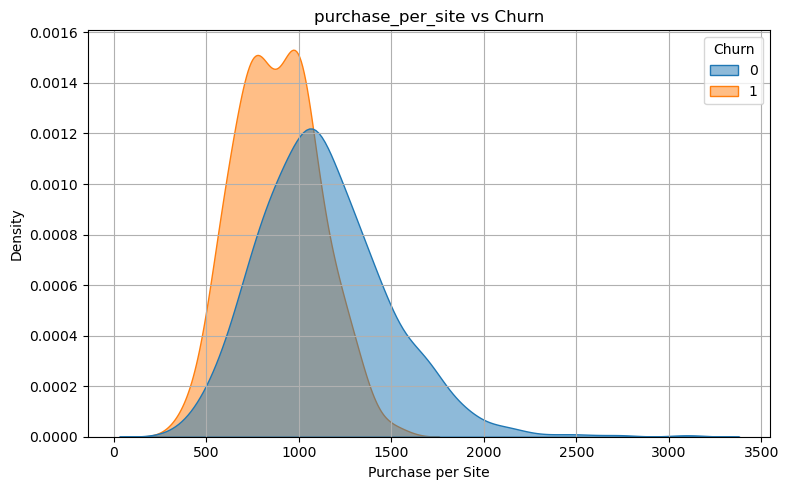

In [2133]:
# 시각화 2: 사이트당 평균 구매 vs 이탈 여부
plt.figure(figsize=(8, 5))

sns.kdeplot(data=df_cleaned, x="purchase_per_site", hue="Churn", fill=True, common_norm=False, alpha=0.5)

plt.title("purchase_per_site vs Churn")
plt.xlabel("Purchase per Site")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

# purchase_per_site가 낮은 고객일수록 이탈 가능성이 높음 → 가치가 낮다고 느낄 수 있음

### 모델 학습 및 평가

**1. LogisticRegression**

In [2137]:
# 로지스틱 회귀 모델 학습
logi = LogisticRegression()
logi.fit(scaled_train, y_train)

# 학습 및 테스트 데이터 정확도 출력
print("Train Accuracy:", logi.score(scaled_train, y_train))
print("Test Accuracy:", logi.score(scaled_test, y_test))

Train Accuracy: 0.8926974664679582
Test Accuracy: 0.8928571428571429


In [2139]:
# test data에 대한 예측
logi.predict(scaled_test)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [2141]:
# 예측 확률 계산 (양성 클래스에 대한 확률)
logi_proba = logi.predict_proba(scaled_test)[:, 1]
logi_proba

array([1.98808391e-04, 5.82077872e-02, 1.37135758e-01, 3.09192697e-01,
       6.56724247e-01, 3.71635356e-01, 5.66771203e-02, 6.89835276e-03,
       3.72115447e-02, 9.42809720e-01, 1.53840036e-02, 1.36732348e-01,
       2.83380625e-02, 1.03128051e-02, 9.90624604e-03, 4.59700887e-01,
       3.01792902e-01, 2.30202301e-02, 1.71643409e-02, 3.08892845e-03,
       7.01823957e-02, 7.68726496e-01, 3.23720633e-02, 9.65122482e-01,
       4.83247637e-01, 4.89158562e-03, 4.23162029e-01, 3.77840523e-02,
       1.60751743e-02, 4.07677174e-03, 6.55531399e-02, 2.89860305e-01,
       6.95670145e-01, 3.63539539e-01, 3.42734576e-01, 7.69353033e-02,
       4.10869026e-02, 6.62003179e-01, 3.08078969e-02, 3.33392501e-01,
       5.70030717e-03, 2.03096510e-03, 2.74467333e-02, 2.01166344e-02,
       3.05682318e-02, 3.66921554e-02, 6.55820663e-01, 7.73923268e-02,
       5.81992896e-01, 9.71447157e-01, 5.51232887e-01, 3.04127471e-01,
       1.90708350e-02, 9.63534635e-02, 2.43399909e-01, 8.17688152e-02,
      

In [2143]:
print(np.round(logi_proba, decimals = 3))

[0.    0.058 0.137 0.309 0.657 0.372 0.057 0.007 0.037 0.943 0.015 0.137
 0.028 0.01  0.01  0.46  0.302 0.023 0.017 0.003 0.07  0.769 0.032 0.965
 0.483 0.005 0.423 0.038 0.016 0.004 0.066 0.29  0.696 0.364 0.343 0.077
 0.041 0.662 0.031 0.333 0.006 0.002 0.027 0.02  0.031 0.037 0.656 0.077
 0.582 0.971 0.551 0.304 0.019 0.096 0.243 0.082 0.034 0.883 0.127 0.001
 0.117 0.604 0.022 0.209 0.004 0.042 0.003 0.061 0.257 0.009 0.009 0.905
 0.428 0.04  0.067 0.478 0.36  0.04  0.119 0.873 0.242 0.177 0.008 0.089
 0.011 0.028 0.064 0.015 0.14  0.01  0.002 0.038 0.009 0.25  0.057 0.003
 0.027 0.033 0.037 0.968 0.055 0.504 0.001 0.006 0.006 0.049 0.062 0.001
 0.033 0.005 0.777 0.032 0.556 0.209 0.002 0.231 0.859 0.862 0.96  0.017
 0.028 0.057 0.54  0.017 0.073 0.057 0.146 0.256 0.002 0.004 0.016 0.005
 0.07  0.309 0.013 0.047 0.148 0.07  0.058 0.043 0.011 0.091 0.191 0.081
 0.37  0.013 0.025 0.283 0.072 0.008 0.143 0.73  0.008 0.003 0.001 0.002
 0.029 0.042 0.03  0.028 0.028 0.148 0.106 0.068 0.

In [2145]:
logi.classes_

array([0, 1], dtype=int64)

In [2147]:
# ROC AUC 점수 계산
logi_auc = roc_auc_score(y_test, logi_proba)
logi_auc

0.9303859306301905

**2. SGDClassifier**

In [2150]:
sgd = SGDClassifier(loss='log_loss', random_state=26)  # 'log_loss' = 로지스틱 회귀
sgd.fit(scaled_train, y_train)

SGDClassifier(loss='log_loss', random_state=26)

In [2152]:
sgd_scores = sgd.decision_function(scaled_test)

In [2154]:
sgd_auc = roc_auc_score(y_test, sgd_scores)
sgd_auc

0.8960674157303371

**3. RandomForestClassifier**

In [2157]:
# rf = RandomForestClassifier(random_state=26)
rf = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=26)
rf.fit(scaled_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=200, random_state=26)

In [2159]:
rf_proba = rf.predict_proba(scaled_test)[:, 1]

In [2161]:
rf_auc = roc_auc_score(y_test, rf_proba)
rf_auc

0.9130434782608696

### roc_auc_score 결과

In [2164]:
# 학습 및 평가 모델 정의 (총 5가지)
models = {
    "LogisticRegression": LogisticRegression(),
    "SGDClassifier": SGDClassifier(loss="log_loss", random_state=26),
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=6, random_state=26),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
}

In [2166]:
# 12. 결과 저장용 리스트
results = []

In [2168]:
# 13. 모델 학습 및 평가 반복
for name, model in models.items():
    model.fit(scaled_train, y_train)                # 모델 학습
    proba = model.predict_proba(scaled_test)[:, 1]  # 이탈 확률 예측
    auc = roc_auc_score(y_test, proba)              # 평가 지표: ROC AUC
    results.append((name, round(auc, 4)))           # 결과 저장

In [2169]:
# 14. 결과 정렬 및 출력
results.sort(key=lambda x: x[1], reverse=True)
print("📊 모델별 ROC AUC 성능 비교:\n")
print("| 모델                     | ROC AUC  |")
print("| ------------------------ | -------- |")
for name, auc in results:
    print(f"| {name:<24} | {auc:<8} |")

📊 모델별 ROC AUC 성능 비교:

| 모델                     | ROC AUC  |
| ------------------------ | -------- |
| LogisticRegression       | 0.9304   |
| RandomForest             | 0.913    |
| SGDClassifier            | 0.8961   |
| GradientBoosting         | 0.8735   |


### 이탈 확률 예측값

In [2242]:
new_customers = pd.read_csv("./data/new_customers.csv")

In [2244]:
new_customers.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company
Andrew Mccall,37.0,9935.53,1,7.71,8.0,2011-08-29 18:37:54,"38612 Johnny Stravenue Nataliebury, WI 15717-8316",King Ltd,NaN
Michele Wright,23.0,7526.94,1,9.28,15.0,2013-07-22 18:19:54,"21083 Nicole Junction Suite 332, Youngport, ME...",Cannon-Benson,NaN
Jeremy Chang,65.0,100.00,1,1.00,15.0,2006-12-11 07:48:13,"085 Austin Views Lake Julialand, WY 63726-4298",Barron-Robertson,NaN
Megan Ferguson,32.0,6487.50,0,9.40,14.0,2016-10-28 05:32:13,"922 Wright Branch North Cynthialand, NC 64721",Sexton-Golden,NaN
Taylor Young,32.0,13147.71,1,10.00,8.0,2012-03-20 00:36:46,Unit 0789 Box 0734 DPO AP 39702,Wood LLC,NaN


In [2246]:
new_customers.index

Index(['Andrew Mccall', 'Michele Wright', 'Jeremy Chang', 'Megan Ferguson',
       'Taylor Young', 'Jessica Drake'],
      dtype='object')

In [2248]:
new_customers.columns

Index(['Names', 'Age', 'Total_Purchase', 'Account_Manager', 'Years',
       'Num_Sites', 'Onboard_date', 'Location', 'Company'],
      dtype='object')

In [2250]:
new_customers.shape

(6, 9)

In [2252]:
with open("./data/new_customers.csv", encoding="utf-8") as f:
    for _ in range(5):
        print(f.readline())

Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company

Andrew Mccall,37.0,9935.53,1,7.71,8.0,2011-08-29 18:37:54,"38612 Johnny Stravenue Nataliebury, WI 15717-8316",King Ltd,

Michele Wright,23.0,7526.94,1,9.28,15.0,2013-07-22 18:19:54,"21083 Nicole Junction Suite 332, Youngport, ME 23686-4381",Cannon-Benson

Jeremy Chang,65.0,100.0,1,1.0,15.0,2006-12-11 07:48:13,"085 Austin Views Lake Julialand, WY 63726-4298",Barron-Robertson

Megan Ferguson,32.0,6487.5,0,9.4,14.0,2016-10-28 05:32:13,"922 Wright Branch North Cynthialand, NC 64721",Sexton-Golden



In [2254]:
new_customers = pd.read_csv("./data/new_customers.csv", index_col=False)

In [2256]:
new_customers.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company
0,Andrew Mccall,37.0,9935.53,1,7.71,8.0,2011-08-29 18:37:54,"38612 Johnny Stravenue Nataliebury, WI 15717-8316",King Ltd
1,Michele Wright,23.0,7526.94,1,9.28,15.0,2013-07-22 18:19:54,"21083 Nicole Junction Suite 332, Youngport, ME...",Cannon-Benson
2,Jeremy Chang,65.0,100.00,1,1.00,15.0,2006-12-11 07:48:13,"085 Austin Views Lake Julialand, WY 63726-4298",Barron-Robertson
3,Megan Ferguson,32.0,6487.50,0,9.40,14.0,2016-10-28 05:32:13,"922 Wright Branch North Cynthialand, NC 64721",Sexton-Golden
4,Taylor Young,32.0,13147.71,1,10.00,8.0,2012-03-20 00:36:46,Unit 0789 Box 0734 DPO AP 39702,Wood LLC


In [2258]:
# 문자열로 잘못 인식된 숫자형 컬럼들을 변환
numeric_cols = ["Age", "Total_Purchase", "Account_Manager", "Years", "Num_Sites"]
for col in numeric_cols:
    new_customers[col] = pd.to_numeric(new_customers[col], errors="coerce")

In [2260]:
# Onboard_date 변환 및 파생 변수 생성
new_customers["Onboard_date"] = pd.to_datetime(new_customers["Onboard_date"], errors="coerce")
new_customers["purchase_per_site"] = new_customers["Total_Purchase"] / (new_customers["Num_Sites"] + 1)
new_customers["days_since_last_contact"] = (pd.to_datetime("today") - new_customers["Onboard_date"]).dt.days

In [2262]:
# 결측치 처리
new_customers.fillna({
    "Age": new_customers["Age"].mean(),
    "Total_Purchase": new_customers["Total_Purchase"].mean(),
    "Years": new_customers["Years"].mean(),
    "Num_Sites": new_customers["Num_Sites"].median(),
    "Account_Manager": new_customers["Account_Manager"].mode()[0],
    "purchase_per_site": new_customers["purchase_per_site"].median(),
    "days_since_last_contact": new_customers["days_since_last_contact"].median()
}, inplace=True)

In [2264]:
# 동일한 특성 리스트 정의
features = [
    "Age", "Total_Purchase", "Account_Manager", "Years", "Num_Sites",
    "purchase_per_site", "days_since_last_contact"
]

In [2266]:
# 예측을 위한 입력 생성 및 스케일링
X_new = new_customers[features]
X_new_scaled = scaler.transform(X_new)

In [2268]:
# 이탈 확률 예측
new_proba = model.predict_proba(X_new_scaled)[:, 1]
new_preds = model.predict(X_new_scaled)

In [2270]:
# 결과 정리
result = new_customers[["Names", "Company", "Location"]].copy()
result["Churn_Probability"] = np.round(new_proba, 4)
result["Churn_Prediction"] = np.where(new_preds == 1, "Churn", "No Churn")

In [2276]:
# 전체 예측 결과 출력
print(result)

            Names           Company  \
0   Andrew Mccall          King Ltd   
1  Michele Wright     Cannon-Benson   
2    Jeremy Chang  Barron-Robertson   
3  Megan Ferguson     Sexton-Golden   
4    Taylor Young          Wood LLC   
5   Jessica Drake     Parks-Robbins   

                                            Location  Churn_Probability  \
0  38612 Johnny Stravenue Nataliebury, WI 15717-8316             0.0039   
1  21083 Nicole Junction Suite 332, Youngport, ME...             0.8777   
2     085 Austin Views Lake Julialand, WY 63726-4298             0.9660   
3      922 Wright Branch North Cynthialand, NC 64721             0.6465   
4                    Unit 0789 Box 0734 DPO AP 39702             0.0076   
5  1148 Tina Stravenue Apt. 978 South Carlos TX 2...             0.0128   

  Churn_Prediction  
0         No Churn  
1            Churn  
2            Churn  
3            Churn  
4         No Churn  
5         No Churn  


In [2280]:
result.to_csv("./data/new_customer_churn_predictions.csv", index=False)